### Notebook to check post processing pipeline. Here, inference is ran of the whole slide validation image data (dtv2) and PQ is computed for the given model

In [ ]:
# Name experiment
experiment_name = "dtvpl-exp-5"

In [1]:
# Import libs
import os 
import time
import cv2
from tqdm import tqdm
import numpy as np
import skimage.draw
import random
import keras
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy.io as sio
import scipy
import scipy.ndimage
from PIL import Image
from skimage.transform import resize

def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)

    
# Define paths
dataset_name = "test_images" 
base_path = os.path.abspath(".")

# Directory of images to run detection on
TRAIN_IMAGES =  os.path.join(base_path, "dataset", "data_processedv2", "val", "images/")
TRAIN_MASKS = os.path.join(base_path, "dataset", "data_processedv2", "val", "masks/")

# Directory of images to run detection on
VALID_IMAGES =  os.path.join(base_path, "dataset", "data_processedv2", "val", "images/")
VALID_MASKS = os.path.join(base_path, "dataset", "data_processedv2", "val", "masks/")

Using TensorFlow backend.


In [2]:
TRAIN_IMAGES, TRAIN_MASKS

('/home/hasib/hasib/MoNuSAC-ISBI-2020/dataset/data_processedv2/val/images/',
 '/home/hasib/hasib/MoNuSAC-ISBI-2020/dataset/data_processedv2/val/masks/')

In [3]:
VALID_IMAGES, VALID_MASKS

('/home/hasib/hasib/MoNuSAC-ISBI-2020/dataset/data_processedv2/val/images/',
 '/home/hasib/hasib/MoNuSAC-ISBI-2020/dataset/data_processedv2/val/masks/')

In [4]:

def read_nuclei(path):
    "read raw data"

    # Load 4-channel image
    img = skimage.io.imread(path)
    
    # input image
    if len(img.shape) > 2:
        img = img[:,:,:3]
    # mask
    else:
        # do nothing
        pass
        
    return img



def save_nuclei(path, img):
    "save image"
    skimage.io.imsave(path, img)
    
    
    
    
# Compute Panoptic quality metric for each image
def Panoptic_quality(ground_truth_image,predicted_image):
    TP = 0
    FP = 0
    FN = 0
    sum_IOU = 0
    matched_instances = {}# Create a dictionary to save ground truth indices in keys and predicted matched instances as velues
                        # It will also save IOU of the matched instance in [indx][1]

    # Find matched instances and save it in a dictionary
    for i in np.unique(ground_truth_image):
        if i == 0:
            pass
        else:
            temp_image = np.array(ground_truth_image)
            temp_image = temp_image == i
            matched_image = temp_image * predicted_image
        
            for j in np.unique(matched_image):
                if j == 0:
                    pass
                else:
                    pred_temp = predicted_image == j
                    intersection = sum(sum(temp_image*pred_temp))
                    union = sum(sum(temp_image + pred_temp))
                    IOU = intersection/union
                    if IOU> 0.5:
                        matched_instances [i] = j, IOU 
                        
    # Compute TP, FP, FN and sum of IOU of the matched instances to compute Panoptic Quality               
                        
    pred_indx_list = np.unique(predicted_image)
    pred_indx_list = np.array(pred_indx_list[1:])

    # Loop on ground truth instances
    for indx in np.unique(ground_truth_image):
        if indx == 0:
            pass
        else:
            if indx in matched_instances.keys():
                pred_indx_list = np.delete(pred_indx_list, np.argwhere(pred_indx_list == [indx][0]))
                TP = TP+1
                sum_IOU = sum_IOU+matched_instances[indx][1]
            else:
                FN = FN+1
    FP = len(np.unique(pred_indx_list))
    PQ = sum_IOU/(TP+0.5*FP+0.5*FN)
    
    return PQ

Index:  59
(1423, 1619, 3) (1423, 1619)
Ground truth classes:  [0 1 2]


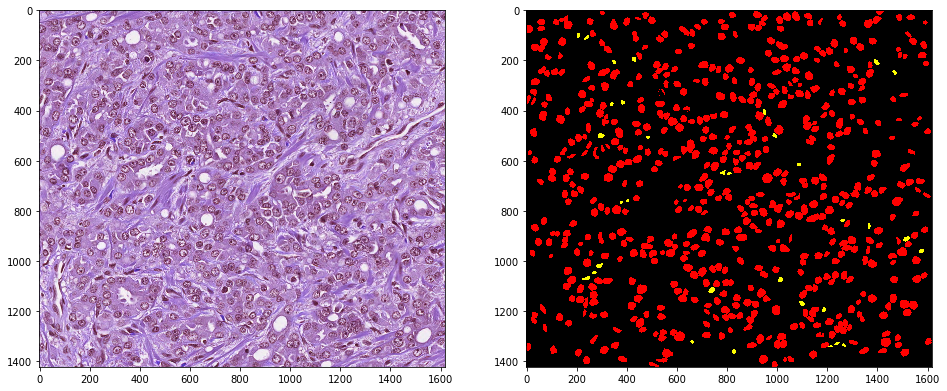

In [5]:
# Load a random image from the images folder
image_fns = sorted(next(os.walk(TRAIN_IMAGES))[2])
gt_fns = sorted(next(os.walk(TRAIN_MASKS))[2])


idx = random.randrange(len(image_fns)) # 94 
print("Index: ", idx)


image = skimage.io.imread(os.path.join(TRAIN_IMAGES, image_fns[idx]))
gt = skimage.io.imread(os.path.join(TRAIN_MASKS, gt_fns[idx]))

assert image.shape[:2] == gt.shape, "Wrong image or ground truth!"
assert image.dtype == gt.dtype, "Wrong data types!"

print(image.shape, gt.shape)

val1 = gt.flatten()
print("Ground truth classes: ", np.unique(val1))

#label_map = {'Epithelial':1,
#             'Lymphocyte':2,
#             'Macrophage':4,
#             'Neutrophil':3,
#            }

# Stolen from https://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale 
norm=plt.Normalize(0,4) # 5 classes including BG
map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])
#map_name = 'magma'

f, axarr = plt.subplots(1,2, figsize=(16,16))

# idx = 154 all classes
axarr[0].imshow(image, cmap=map_name, norm=norm)
axarr[1].imshow(gt, cmap=map_name, norm=norm)

In [ ]:
import efficientnet.tfkeras
from tensorflow.keras.models import load_model

log_path = os.path.join(base_path, "logs", experiment_name)

model = None
model = load_model('{}/{}.h5'.format(log_path, experiment_name), compile=False)
#model.summary()

In [ ]:
# SAME CODE BLOCK AS IN 6_inference.ipynb

import numpy as np
from skimage.transform import resize

# Helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    
    norm=plt.Normalize(0,4) # 5 classes including BG
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])

    
    n = len(images)
    plt.figure(figsize=(12, 12))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap=map_name, norm=norm)
    plt.show()
    
    
    
def prep(img):
    img = img.astype('float32')
    img = (img > 0.5).astype(np.uint8)  # threshold
    img = resize(img, (image_cols, image_rows), preserve_range=True)
    return img




def visualize_results(image, mask):
    
    f, axarr = plt.subplots(1,2, figsize=(16, 16))
    
    norm=plt.Normalize(0,4) # 5 classes including BG
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])

    axarr[0].imshow(image)
    axarr[1].imshow(mask, cmap=map_name, norm=norm)


    
def vis_gray(image, mask):
    
    f, axarr = plt.subplots(1,2, figsize=(16, 16))
    
    axarr[0].imshow(image)
    axarr[1].imshow(mask, cmap='gray')
    
    
    
    
def sliding_window(image, step, window):
    
    x_loc = []
    y_loc = []
    cells = []
    
    for y in range(0, image.shape[0], step):
        for x in range(0, image.shape[1], step):
            cells.append(image[y:y + window[1], x:x + window[0]])
            x_loc.append(x)
            y_loc.append(y)
            
    return x_loc, y_loc, cells




def predict(im):
    """Predict on patch"""
    
    im = np.expand_dims(im, axis=0)
    
    im = model.predict(im)
    im = np.argmax(im.squeeze(), axis=-1)
 
    assert im.shape == (64, 64), "Wrong shape, {}!".format(im.shape)
    
    return im



def whole_slide_predict(whole_image):
    
    # If input image less than patch, infer on whole image
    if whole_image.shape[0] < 64 or whole_image.shape[1] < 64:
        
        # Get size
        raw_dim = (whole_image.shape[1], whole_image.shape[0]) # W, H
        
        # Resize to 64x64 for prediction
        whole_image_rs = cv2.resize(whole_image, (64, 64), interpolation = cv2.INTER_AREA)
        #whole_image_rs = resize(whole_image, (64, 64), preserve_range=True)
        
        # Infer
        pred = predict(whole_image_rs)
        
        # Change dtype for resizing back to original shape
        pred = pred.astype(np.uint8)
        
        # Resize back to original shape
        pred = cv2.resize(pred, raw_dim, interpolation = cv2.INTER_AREA)
        #pred = resize(pred, raw_dim, preserve_range=True)
        
    
    else:
        
        # Get patch locations
        x_pos, y_pos, cells = sliding_window(whole_image, 8, (64, 64)) 

        # Array for storing predictions
        pred = np.zeros((whole_image.shape[0], whole_image.shape[1]))

        # Slide over each patch
        for (x, y, cell) in zip(x_pos, y_pos, cells):

            # Get patch
            patch = whole_image[y:y + 64, x:x + 64]

            # Get size
            raw_dim = (patch.shape[1], patch.shape[0]) # W, H

            # If less than patch size, resize and then run prediction
            if raw_dim != (64, 64):


                # Resize to 64x64
                patch_rs = cv2.resize(patch, (64, 64), interpolation = cv2.INTER_AREA)
                #patch_rs = resize(patch, (64, 64), preserve_range=True)
                #patch_rs = patch_rs.astype(np.uint8)
                
                assert patch.dtype == patch_rs.dtype, "Wrong data type after resizing!"

                
                # Infer
                processed = predict(patch_rs)
                
                # Change dtype for resizing to original shape
                processed = processed.astype(np.uint8)


                # Resize back to original shape
                processed = cv2.resize(processed, raw_dim, interpolation = cv2.INTER_AREA)
                #processed = resize(processed, raw_dim, preserve_range=True)
                
                # Change dtype 
                processed = processed.astype(np.uint8)
                
                assert patch.shape[:2] == processed.shape, "Wrong shape!"
                assert patch.dtype == processed.dtype, "Wrong data type in prediction!"

            else:

                
                # Infer
                processed = predict(patch)
                
                # Change dtype
                processed = processed.astype(np.uint8)

                #print(patch.dtype, processed.dtype)

                assert patch.shape[:2] == processed.shape, "Wrong shape!"
                assert patch.dtype == processed.dtype, "Wrong data type in prediction!"


            # Add in image variable
            pred[y:y + 64, x:x + 64] = processed 
            processed = None

    return pred


In [ ]:
# Compute on arbitary images

for i in range(3):
    
    idx = random.randrange(len(image_fns))
    #print("Index: ", idx)
    
    # Read image and ground truth
    image = skimage.io.imread(os.path.join(IMAGES_DEST, image_fns[idx]))
    gt = skimage.io.imread(os.path.join(MASKS_DEST, gt_fns[idx]))
    
    # Predict input image
    pred = whole_slide_predict(image)
    
    # Post processing to refine predictions
    pred_filt = cv2.medianBlur(pred.astype(np.uint8), 5)
    
    print(image.shape, gt.shape, pred.shape)
    
    # Display image label and prediction
    pq_g = Panoptic_quality(gt, gt)
    pq = Panoptic_quality(gt, pred)
    pq_f = Panoptic_quality(gt, pred_filt)
    
    print("PQ of gt, pred and pred with medfil: ", pq_g, pq, pq_f)
    
    visualize(
            image=image,
            GT_mask = gt,
            Predicted_mask = pred,
            Filtered_mask = pred_filt
        )
    
    assert image.shape[:2] == pred.shape, "Image missmatch"

### Compute PQ on WS training set

In [ ]:
image_fns = sorted(next(os.walk(TRAIN_IMAGES))[2])
gt_fns = sorted(next(os.walk(TRAIN_MASKS))[2])


for i in range(len(images_fns)):
    
    # Read image and ground truth
    image = skimage.io.imread(os.path.join(TRAIN_IMAGES, image_fns[idx]))
    gt = skimage.io.imread(os.path.join(TRAIN_MASKS, gt_fns[idx]))
    
    # Predict input image
    pred = whole_slide_predict(image)
    
    # Post processing to refine predictions
    pred_filt = cv2.medianBlur(pred.astype(np.uint8), 5)
    
    print(image.shape, gt.shape, pred.shape)
    
    # Display image label and prediction
    pq_g = Panoptic_quality(gt, gt)
    pq = Panoptic_quality(gt, pred)
    pq_f = Panoptic_quality(gt, pred_filt)
    
    print("PQ of gt, pred and pred with medfil: ", pq_g, pq, pq_f)
    
    visualize(
            image=image,
            GT_mask = gt,
            Predicted_mask = pred,
            Filtered_mask = pred_filt
        )
    
    assert image.shape[:2] == pred.shape, "Image missmatch"

### Compute PQ on WS validation set

In [ ]:
image_fns = sorted(next(os.walk(VALID_IMAGES))[2])
gt_fns = sorted(next(os.walk(VALID_MASKS))[2])

pqs = []
pqs_f = []
pqs_gold = []


for i in range(len(images_fns)):
    
    # Read image and ground truth
    image = skimage.io.imread(os.path.join(VALID_IMAGES, image_fns[idx]))
    gt = skimage.io.imread(os.path.join(VALID_MASKS, gt_fns[idx]))
    
    # Predict input image
    pred = whole_slide_predict(image)
    
    # Post processing to refine predictions
    pred_filt = cv2.medianBlur(pred.astype(np.uint8), 5)
    pred_filt = pred_filt.astype(np.int64)
    
    print(image.shape, gt.shape, pred.shape)
    
    # Display image label and prediction
    pq_g = Panoptic_quality(gt, gt)
    pq = Panoptic_quality(gt, pred)
    pq_f = Panoptic_quality(gt, pred_filt)
    
    
    print("PQ of gt, pred and pred with medfil: ", pq_g, pq, pq_f)
    
    visualize(
            image=image,
            GT_mask = gt,
            Predicted_mask = pred,
            Filtered_mask = pred_filt
        )
    pq_gold = Panoptic_quality(gt, gt)
    pq = Panoptic_quality(gt, pred)
    pqf = Panoptic_quality(gt, pred_filt)
    
    pqs_gold.append(pq_gold)
    pqs.append(pq)
    pqs_f.append(pqf)
    
    assert image.shape[:2] == pred.shape, "Image missmatch"
    

pqs = np.mean(np.array(pqs))
pqs_f = np.mean(np.array(pqs_f))
pqs_gold = np.mean(np.array(pqs_gold))

print("Mean PQ gold standard: ", pqs_gold)
print("Mean PQ without filer: ", pqs)
print("Mean PQ without filer: ", pqs_f)

In [6]:
#pqs = []
#pqs_f = []
#pqs_gold = []

#for i in tqdm(range(len(image_fns))):
    
    # Read image and ground truth
#    image = skimage.io.imread(os.path.join(IMAGES_DEST, image_fns[i]))
#    gt = skimage.io.imread(os.path.join(MASKS_DEST, gt_fns[i]))
    
    # Predict input image
#    pred = whole_slide_predict(image)
    
    # Post processing to refine predictions
#    pred_filt = cv2.medianBlur(pred.astype(np.uint8), 5)
#    pred_filt = pred_filt.astype(np.int64)
    
    #print(image.shape, gt.shape, pred.shape)
    
    # Display image label and prediction
    #visualize(
    #        image=image,
    #        GT_mask = gt,
    #        Predicted_mask = pred
    #    )
    
#    pq_gold = Panoptic_quality(gt, gt)
#    pq = Panoptic_quality(gt, pred)
#    pqf = Panoptic_quality(gt, pred_filt)
    
#    pqs_gold.append(pq_gold)
#    pqs.append(pq)
#    pqs_f.append(pqf)
    

#pqs = np.mean(np.array(pqs))
#pqs_f = np.mean(np.array(pqs_f))
#pqs_gold = np.mean(np.array(pqs_gold))

#print("Mean PQ gold standard: ", pqs_gold)
#print("Mean PQ without filer: ", pqs)
#print("Mean PQ without filer: ", pqs_f)